# COVID19 model

In [1]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("C:/git/case7-lockdown-exit-strategy/")

from pyepidemics.models.examples.covid import COVID19
from pyepidemics.dataset import fetch_daily_case_france

# Optimizing parameters on French cases

## Getting data

In [3]:
cases = fetch_daily_case_france()
cases.head()

,cas_confirmes,deces,gueris,hospitalises,reanimation,Is,D,R,H,ICU
2020-01-24,3.0,0.0,0.0,3.0,0.0,2.761419,0.0,0.0,2.761481,0.0
2020-01-25,3.0,0.0,0.0,3.0,0.0,2.964313,0.0,1.0,2.964423,1.0
2020-01-26,3.0,0.0,0.0,3.0,0.0,3.219465,0.0,1.0,3.219620,1.0
2020-01-27,3.0,0.0,0.0,3.0,0.0,3.586868,0.0,1.0,3.587032,1.0
2020-01-28,4.0,0.0,0.0,4.0,1.0,4.106566,1.0,1.0,4.106629,1.0


https://medium.com/analytics-vidhya/how-to-predict-when-the-covid-19-pandemic-will-stop-in-your-country-with-python-d6fbb2425a9f

In [4]:
from scipy.optimize import curve_fit

In [5]:
def logistic_f(X, c, k, m):
    y = c / (1 + np.exp(-k*(X-m)))
    return y

def gaussian_f(X, a, mu, sigma):
    y = a * np.exp(-0.5 * ((X-mu)/sigma)**2)
    return y

## Fitting death cases with sigmoid

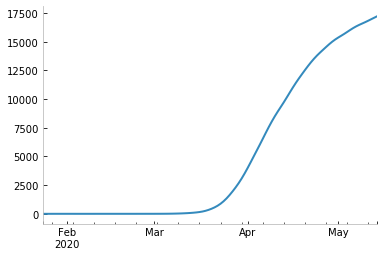

In [6]:
cases["D"].plot()

In [7]:
model,cov = curve_fit(logistic_f,
                     xdata = np.arange(len(cases)),
                     ydata = cases["D"].values,
                     )

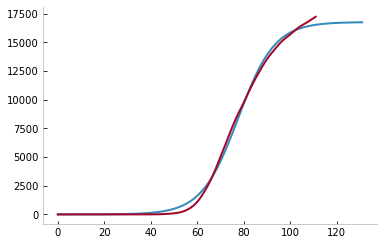

In [8]:
plt.plot(logistic_f(np.arange(len(cases)+20),*model))
plt.plot(cases["D"].values)
plt.show()

## Fitting ICU with normal

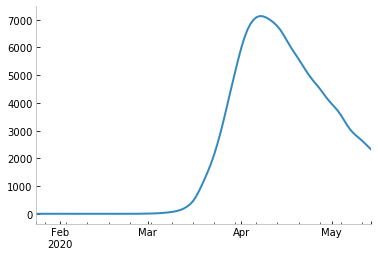

In [9]:
cases["ICU"].plot()

In [10]:
forecast = 10
icu = cases["ICU"].values

model,cov = curve_fit(gaussian_f,
                     xdata = np.arange(len(icu)),
                     ydata = icu,
                     p0=[np.max(icu), np.argmax(icu), 1],
                     )
model

array([6913.11491582,   80.82325335,   15.97898101])

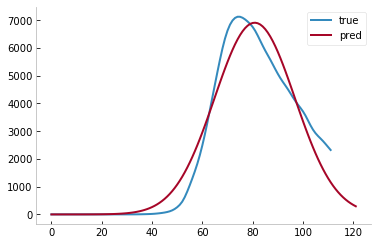

In [11]:
x = np.arange(len(cases)+forecast)

plt.plot(np.arange(len(cases)),icu,label = "true")
plt.plot(x,gaussian_f(x,*model),label = "pred")
plt.legend()
plt.show()

## Fitting ICU with skewed normal

In [12]:
import math
import scipy.special as sp

def skew2(x,  a,mu,sigma,alpha,c):
    normpdf = (1 / (sigma * np.sqrt(2 * math.pi))) * np.exp(-(np.power((x - mu), 2) / (2 * np.power(sigma, 2))))
    normcdf = (0.5 * (1 + sp.erf((alpha * ((x - mu) / sigma)) / (np.sqrt(2)))))
    return 2 * a * normpdf * normcdf + c, max(normpdf)

def skew(x, sigmag, mu, alpha, c, a):
    return skew2(x, sigmag, mu, alpha, c, a)[0]

In [13]:
forecast = 100
icu = cases["ICU"].values

model,cov = curve_fit(skew,
                     xdata = np.arange(len(icu)),
                     ydata = icu,
                     p0=[np.max(icu), np.argmax(icu),1,1,1],
                     )
model

# y_fit, mode = skew2(xdata, *popt[:5])

array([2.92514685e+05, 6.31243778e+01, 2.95742321e+01, 4.36599636e+00,
       2.24452095e+01])

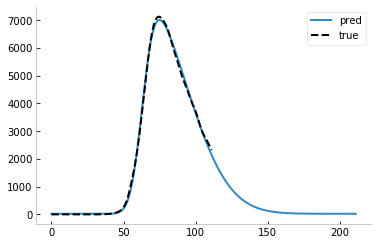

In [14]:
x = np.arange(len(cases)+forecast)

plt.plot(x,skew(x,*model),label = "pred")
plt.plot(np.arange(len(cases)),icu,label = "true",linestyle = "--",color = "black")
plt.legend()
plt.show()

## Prepare extended cases

In [15]:
n_extend = 50
data_extended = {}

for col in ["ICU","H"]:
    data_col = cases[col].values
    model,cov = curve_fit(skew,xdata = np.arange(len(data_col)),ydata = data_col,p0=[np.max(data_col), np.argmax(data_col),1,1,1])
    
    x = np.arange(len(cases)+n_extend)
    data_extended[col] = skew(x,*model)

for col in ["D"]:
    data_col = cases[col].values
    model,cov = curve_fit(logistic_f,xdata = np.arange(len(data_col)),ydata = data_col)
    x = np.arange(len(cases)+n_extend)
    data_extended[col] = logistic_f(x,*model)
    
    
index = pd.date_range(start = cases.index[0],periods = len(cases) + n_extend)
data_extended = pd.DataFrame(data_extended,index = index)

data_extended

,ICU,H,D
2020-01-24,22.445209,-7.268083,0.878952
2020-01-25,22.445209,-7.268083,0.997961
2020-01-26,22.445209,-7.268083,1.133083
2020-01-27,22.445209,-7.268083,1.286499
2020-01-28,22.445209,-7.268083,1.460685
...,...,...,...
2020-06-29,73.642419,4785.166357,16766.165765
2020-06-30,68.405703,4586.382600,16766.249434
2020-07-01,63.657479,4393.854064,16766.323126
2020-07-02,59.357572,4207.488966,16766.388030


In [16]:
cases_extended = cases[["ICU","H","D"]].copy().append(data_extended.iloc[-n_extend:])

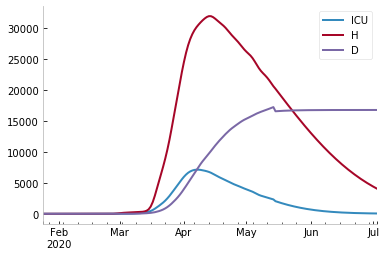

In [17]:
cases_extended.plot()

## Constants

In [18]:
N = 67e6
beta_high = 0.9 # R0 of 3.3
beta_low = 0.16 # R0 of 0.6
init_state = {"S":N-1,"E":1}

## Model without lockdown

In [312]:
model = COVID19(N = N,beta = beta_high)
model.r0(beta_high)

3.4330370993756505

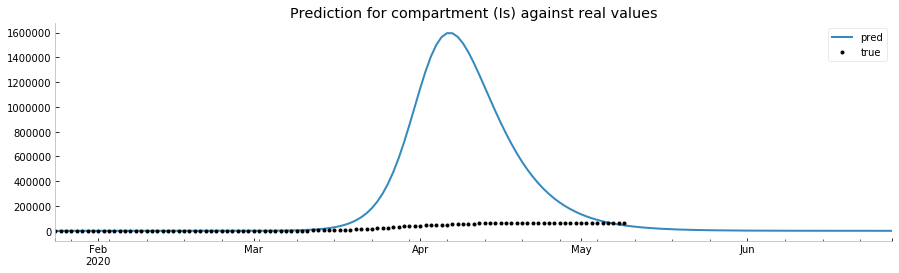

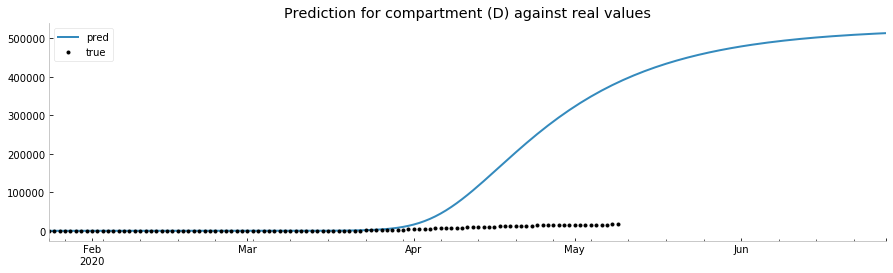

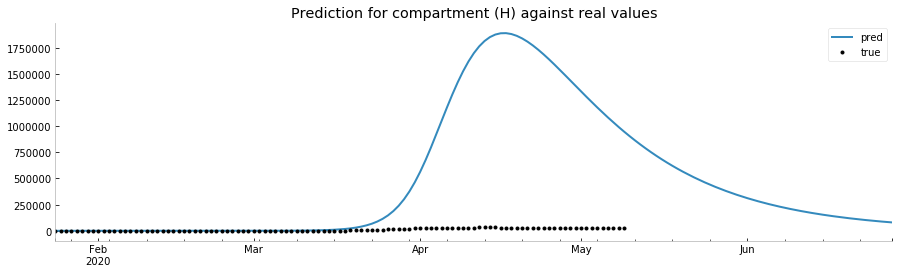

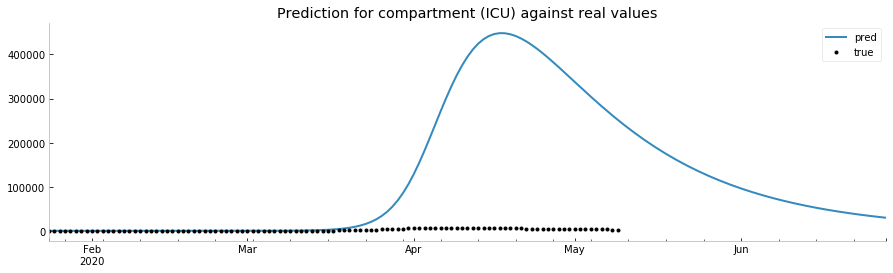

In [14]:
model.show_prediction(cases[["Is","D","H","ICU"]],init_state,forecast_days = 50)

## Model with lockdown

In [18]:
offset = 0
beta = [beta_high,[beta_low],[53-offset]] # We go from R0 around 3.6 to O.6 during lockdown starting at day 53

model = COVID19(N = N,beta = beta,offset = offset)

In [19]:
model.solve(init_state)

,S,E,Ia,Im,Is,H,ICU,D,R
0,6.700000e+07,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00
1,6.700000e+07,8.433239e-01,0.043895,1.740112e-01,0.016136,0.000977,0.000218,0.000002,9.150866e-03
2,6.700000e+07,8.561723e-01,0.076312,3.276245e-01,0.028981,0.003521,0.000787,0.000016,3.371680e-02
3,6.700000e+07,9.895671e-01,0.106299,4.889741e-01,0.041493,0.007361,0.001649,0.000051,7.212469e-02
4,6.700000e+07,1.227269e+00,0.139682,6.789494e-01,0.055687,0.012517,0.002811,0.000115,1.254361e-01
...,...,...,...,...,...,...,...,...,...
96,4.849677e+07,2.022546e+06,474905.186017,5.743785e+06,240367.242501,364615.649267,88066.563942,52149.271913,9.516795e+06
97,4.791897e+07,2.049975e+06,483063.793202,5.877710e+06,244788.521064,374269.945770,90472.768249,54625.336976,9.906127e+06
98,4.733545e+07,2.075906e+06,490956.895827,6.010752e+06,249098.121434,383945.397680,92887.159855,57166.837837,1.030384e+07
99,4.674672e+07,2.100250e+06,498560.185303,6.142653e+06,253283.304946,393627.501996,95306.384010,59773.895499,1.070982e+07


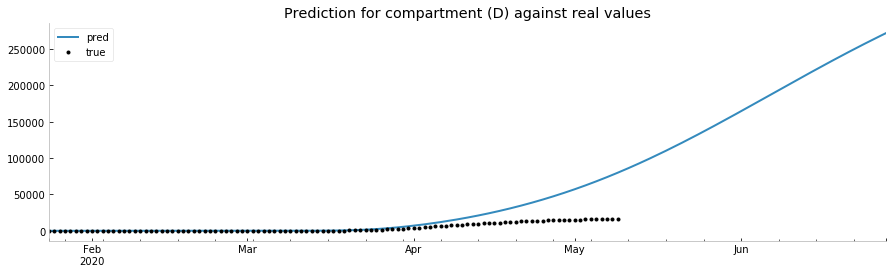

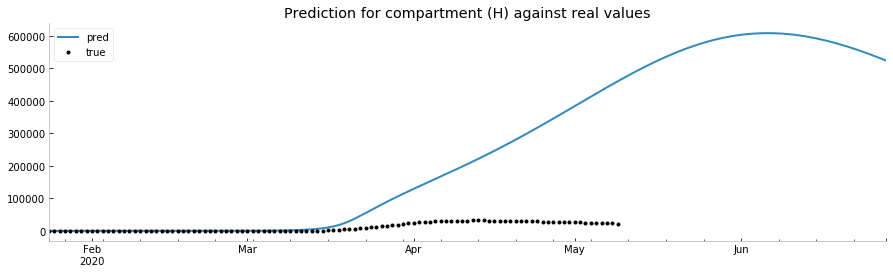

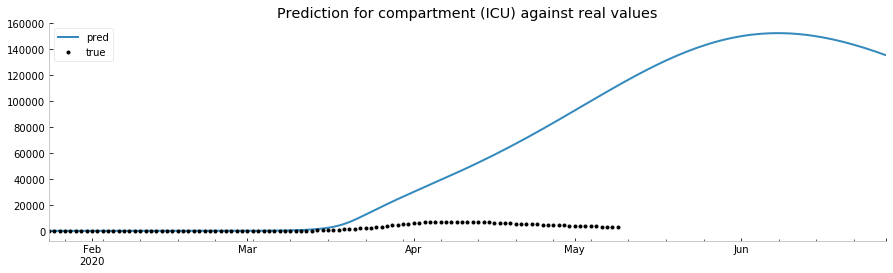

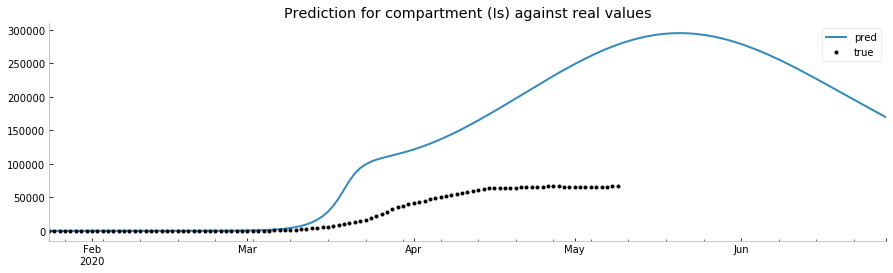

In [20]:
pred = model.show_prediction(cases[["D","H","ICU","Is"]],init_state,forecast_days = 50)

## Optimizing parameters on French cases

In [38]:
space = {
    "beta_low":(0.01,0.4),
    "beta_high":(0.6,1.5),
    "offset":(-50,20),
    "recovery_rate_asymptomatic":(1/8,1/4),
    "recovery_rate_mild":(1/8,1/4),
    "death_rate_hospital":(0.006,0.02),
    "death_rate_icu":(0.006,0.02),
    "recovery_rate_icu":(0.02,0.08),
    "recovery_rate_hospital":(0.02,0.08),
}

def constraint(model,loss):
    
    r0 = model.r0(model.calibrated_params["beta_high"])
#     r0_lockdown = model.r0(model.calibrated_params["beta_low"])
#     reduction = (r0 - r0_lockdown)/r0
    
    if r0 < 3.25 or r0 > 3.4:
        return loss*10
#     if 0.75 > reduction > 0.9:
#         return loss*10 
    else:
        return loss
    

In [39]:
class COVID19Model(COVID19):
    def __init__(self,params = None):
        if params is not None:
            self.reset(params)
        
    def reset(self,params):        
        beta = [params["beta_high"],[params["beta_low"]],[53 - params["offset"]]]
        super().__init__(N = N,
            beta = beta,
            offset = params["offset"],
            recovery_rate_asymptomatic = params["recovery_rate_asymptomatic"],
            recovery_rate_mild = params["recovery_rate_mild"],
            death_rate_icu = params["death_rate_icu"],
            death_rate_hospital = params["death_rate_hospital"],
            recovery_rate_hospital = params["recovery_rate_hospital"],
            recovery_rate_icu = params["recovery_rate_icu"]
                         
        )
        
        self.calibrated_params = params
        
model = COVID19Model()

##### Possible solutions for France

- {'beta_low': 0.19533343854106783, 'beta_high': 1.0218414784484824, 'offset': -1.0219809512460598, 'proba_hospital_to_icu': 0.054172908477597155, 'proba_death_hospital': 0.18790305312043631, 'recovery_duration_hospital': 19.37272416042987, 'recovery_duration_icu': 5.190953177371748, 'death_duration_icu': 14.180518358312929, 'death_duration_hospital': 67.13742586625622} for value 0.1350002488802483

- {'beta_low': 0.24634216728429806, 'beta_high': 1.8347320721720688, 'offset': 19.99927940574788, 'proba_hospital_to_icu': 0.15624158268969202, 'proba_death_hospital': 0.1643094748407844, 'recovery_duration_hospital': 7.2631180160024735, 'recovery_duration_icu': 2.0250261278505524, 'death_duration_icu': 59.30284155266353, 'death_duration_hospital': 12.746333088830141}

- {'beta_low': 0.24634216728429806, 'beta_high': 1.8347320721720688, 'offset': 19.99927940574788, 'proba_hospital_to_icu': 0.15624158268969202, 'proba_death_hospital': 0.1643094748407844, 'recovery_duration_hospital': 7.2631180160024735, 'recovery_duration_icu': 2.0250261278505524, 'death_duration_icu': 59.30284155266353, 'death_duration_hospital': 12.746333088830141}

- {'beta_low': 0.21560843352783274, 'beta_high': 1.3071636918913934, 'offset': 9.806725294711278, 'proba_icu': 0.1530003993721438, 'proba_death_hospital': 0.12452538607170034, 'recovery_duration_hospital': 10.47851241014868, 'recovery_duration_icu': 16.760147420829284, 'death_duration_icu': 17.7063457428586, 'death_duration_hospital': 10.145831431424424}

new model optimized

{'beta_low': 0.18411638684965087, 'beta_high': 1.2734783019670588, 'offset': 9.074093564217458, 'proba_icu': 0.17501270549937065, 'proba_death_hospital': 0.16766022875261, 'recovery_duration_hospital': 16.932956455016168, 'recovery_duration_icu': 17.846233668286427, 'death_duration_icu': 83.77150221349056, 'death_duration_hospital': 11.907883627005415} for value 0.1022033643408922


##### New model

{'beta_low': 0.04714376566499745, 'beta_high': 0.7847107284182065, 'offset': -0.7971673903615053, 'recovery_rate_asymptomatic': 0.19955048390764965, 'recovery_rate_mild': 0.18879686513249672} for value 0.2846271267857744

{'beta_low': 0.04661960578247592, 'beta_high': 0.9880301660445054, 'offset': 7.401855016979188, 'recovery_rate_asymptomatic': 0.22998213975724882, 'recovery_rate_mild': 0.24727011992275366, 'proba_icu': 0.16021406802387553} for value 0.27257100560958725

{'beta_low': 0.054865847187270445, 'beta_high': 0.8103495499233612, 'offset': 1.0454398158468325, 'recovery_rate_asymptomatic': 0.18052073112835418, 'recovery_rate_mild': 0.2151369116913636, 'death_rate_hospital': 0.012971502243633493, 'death_rate_icu': 0.015116019791735392} for value 0.15668173423542947

{'beta_low': 0.05218429774338693, 'beta_high': 0.8972107571143951, 'offset': 5.135037051510192, 'recovery_rate_asymptomatic': 0.19608725811335714, 'recovery_rate_mild': 0.23707601409845797, 'death_rate_hospital': 0.012511506443013614, 'death_rate_icu': 0.009040111218729495, 'recovery_rate_icu': 0.04449715603005916, 'recovery_rate_hospital': 0.04179453791687042} for value 0.12819411731226882

In [44]:
model.fit(cases_extended[["D","H","ICU"]],space,init_state,constraint = constraint,n = 1000,early_stopping = 300)

... Found best solution {'beta_low': 0.10328585754379985, 'beta_high': 1.4495263750490734, 'offset': -9.441205787753008, 'recovery_rate_asymptomatic': 0.19100258818015572, 'recovery_rate_mild': 0.15950949206253362, 'death_rate_hospital': 0.007832016704010401, 'death_rate_icu': 0.016176864523396072, 'recovery_rate_icu': 0.05151148647843983, 'recovery_rate_hospital': 0.04619568943557253} for value 0.18559666379318232
... Parameters saved in yaml file calibration_params_1589549951.yaml


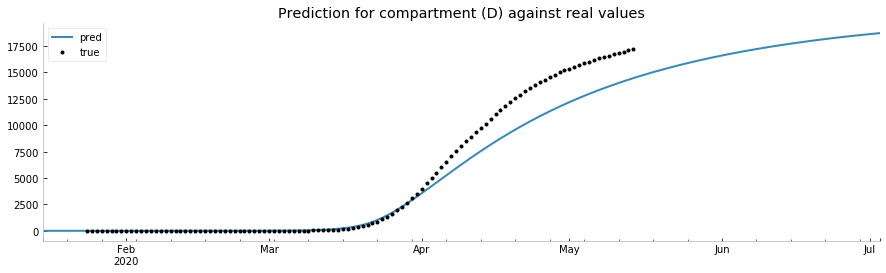

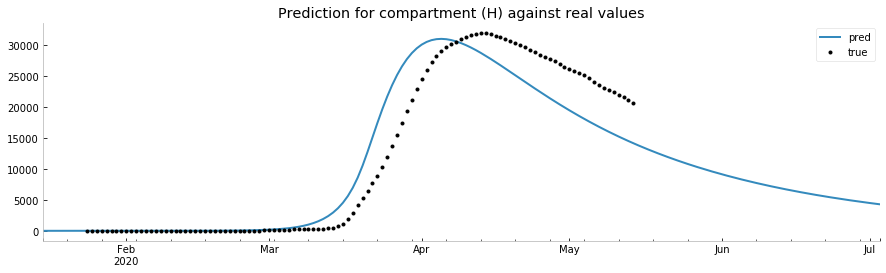

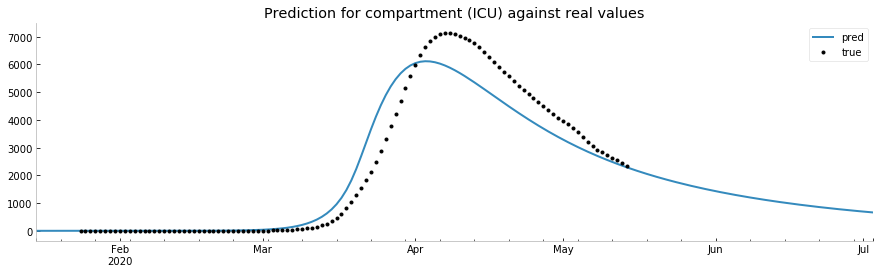

In [47]:
model.show_prediction( cases[["D","H","ICU"]],init_state,forecast_days = 50)

In [46]:
r0 = model.r0(model.calibrated_params["beta_high"])
r0_lockdown = model.r0(model.calibrated_params["beta_low"])
reduction = (r0 - r0_lockdown)/r0

print(r0)
print(r0_lockdown)
print(reduction)

3.321239412880723
0.2366545837125857
0.928745099556879


In [31]:
model.opt.show_history()

In [48]:
model.opt.show_parallel_coordinates()

In [51]:
states = model.predict(cases[["D","H","ICU"]],1)

In [53]:
x_end = states.loc["2020-05-11"]

In [54]:
x_end["R"] / N

0.019005652793146942

In [60]:
params_dist

,beta_high,beta_low,death_rate_hospital,death_rate_icu,offset,recovery_rate_asymptomatic,recovery_rate_hospital,recovery_rate_icu,recovery_rate_mild
452,1.358782,0.123460,0.007661,0.019748,-13.973996,0.179184,0.059764,0.033372,0.151354
459,1.365235,0.134148,0.007707,0.019717,-13.412218,0.178761,0.060386,0.040024,0.150437
480,1.366791,0.139277,0.007155,0.018708,-14.006579,0.180476,0.062452,0.038464,0.148939
572,1.321529,0.160594,0.006440,0.017807,-15.353098,0.177533,0.059524,0.042272,0.143234
644,1.357557,0.151912,0.006846,0.018355,-14.231042,0.179981,0.061641,0.037473,0.141243
712,1.349246,0.151085,0.007375,0.017902,-14.443012,0.180569,0.059997,0.037521,0.141098
781,1.399141,0.123221,0.007724,0.016680,-12.550873,0.184082,0.058058,0.047269,0.151874
785,1.412677,0.118505,0.008051,0.017481,-12.147681,0.184418,0.057962,0.048162,0.154825
795,1.409488,0.107520,0.007723,0.016224,-12.140529,0.181748,0.057622,0.048781,0.154258
805,1.430159,0.112882,0.007841,0.016917,-11.016268,0.186119,0.054758,0.047733,0.157449


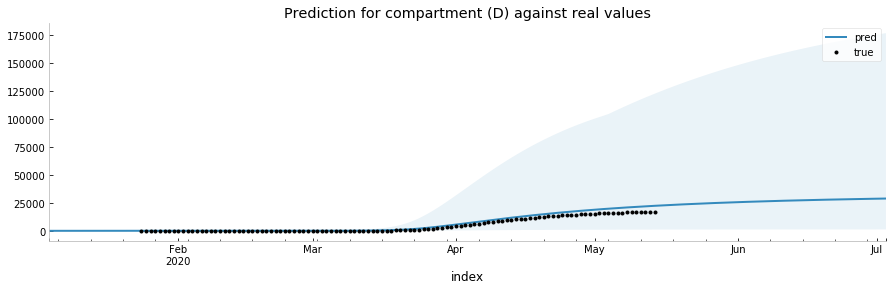

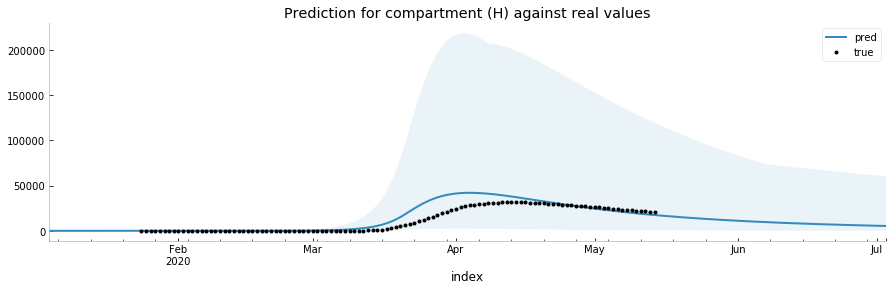

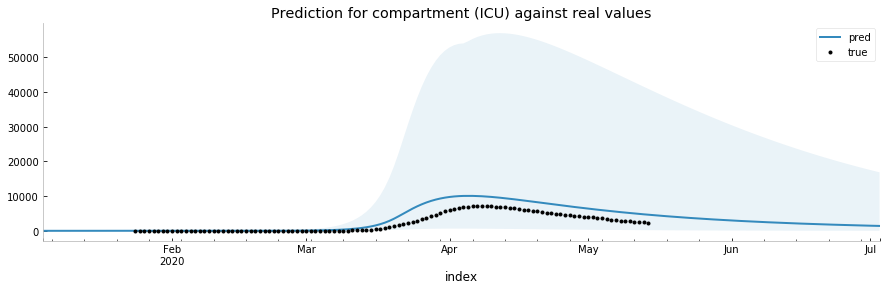

In [55]:
model.show_prediction_interval(cases[["D","H","ICU"]],1,forecast_days=50,q = 0.05)

In [33]:
model.params

{'N': 67000000.0,
 'beta': [0.7483889583391622, [0.05563843820945344], [56.78417724984951]],
 'incubation_rate': 0.27027027027027023,
 'recovery_rate_asymptomatic': 0.2189274187056882,
 'recovery_rate_mild': 0.1709760922127325,
 'recovery_rate_hospital': 0.056620752756844105,
 'recovery_rate_icu': 0.05739274022087378,
 'symptoms_to_icu_rate': 0.14285714285714285,
 'symptoms_to_hospital_rate': 0.18181818181818182,
 'death_rate_hospital': 0.011156849010145162,
 'death_rate_icu': 0.01843015975936666,
 'proba_severe': 0.071,
 'proba_asymptomatic': 0.2,
 'proba_icu': 0.182,
 'isolation_ratio': 0.75}

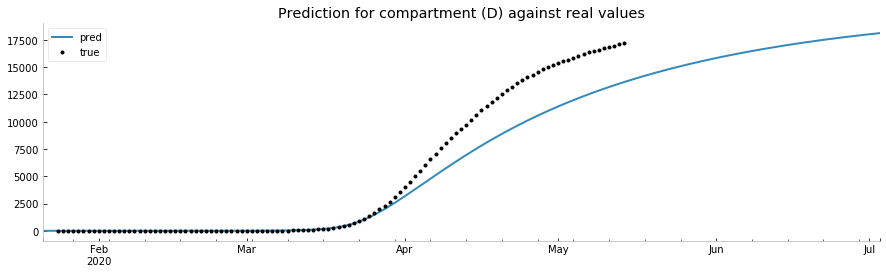

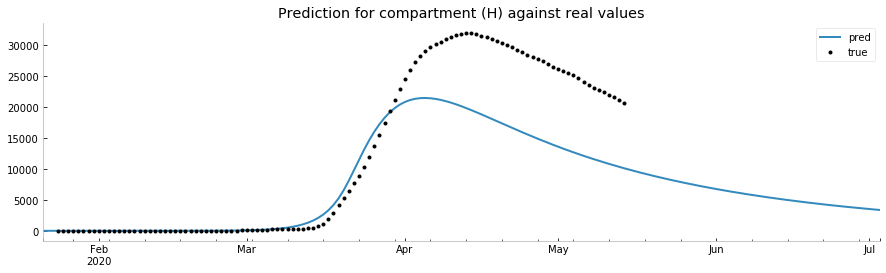

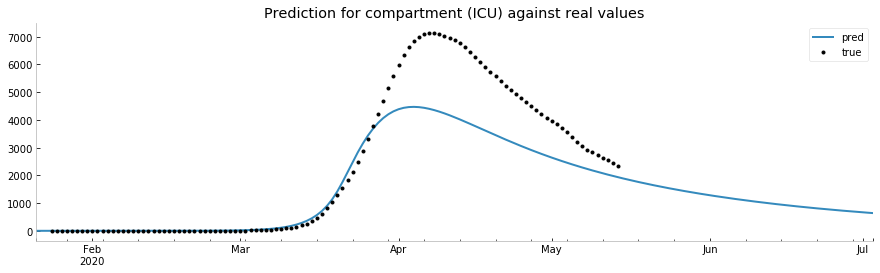

In [35]:
model.show_prediction(cases[["D","H","ICU"]],init_state,forecast_days = 50)

In [56]:
model.opt.estimate_params_distributions(q = 0.05)

{'beta_high': (1.444680001543616, 0.03938571930026215),
 'beta_low': (0.0945657432485924, 0.023368033611807497),
 'death_rate_hospital': (0.00876344003984357, 0.0009479062646716673),
 'death_rate_icu': (0.016617329303860208, 0.0010078823710250608),
 'offset': (-9.94876044277501, 1.8869133636457016),
 'recovery_rate_asymptomatic': (0.19315420811595188, 0.007040605679671827),
 'recovery_rate_hospital': (0.04711554308826746, 0.007661232018069504),
 'recovery_rate_icu': (0.048568862652026736, 0.004876883004171588),
 'recovery_rate_mild': (0.15737866606261555, 0.005292047526039692)}

In [69]:
params_dist = model.opt.estimate_params_distributions(q = 0.05,return_df = True)

In [73]:
params_dist["beta_high"].quantile(0.975)

1.4951854442011474

In [75]:
params_dist = model.opt.estimate_params_distributions(q = 0.05,summary = True)
params_dist

,best,min,max,mu_norm,std_norm,min_norm,max_norm
value,0.185597,0.192990,0.239089,0.218097,0.014785,0.210705,0.225489
beta_high,1.449526,1.351116,1.495185,1.444680,0.039386,1.424987,1.464373
beta_low,0.103286,0.064094,0.151726,0.094566,0.023368,0.082882,0.106250
death_rate_hospital,0.007832,0.006915,0.010127,0.008763,0.000948,0.008289,0.009237
death_rate_icu,0.016177,0.015150,0.019490,0.016617,0.001008,0.016113,0.017121
offset,-9.441206,-14.395319,-7.764779,-9.948760,1.886913,-10.892217,-9.005304
recovery_rate_asymptomatic,0.191003,0.178856,0.202085,0.193154,0.007041,0.189634,0.196675
recovery_rate_hospital,0.046196,0.035401,0.061359,0.047116,0.007661,0.043285,0.050946
recovery_rate_icu,0.051511,0.037484,0.055817,0.048569,0.004877,0.046130,0.051007
recovery_rate_mild,0.159509,0.141691,0.163886,0.157379,0.005292,0.154733,0.160025


In [93]:
0.2 / params_dist.loc["death_rate_icu"]["best"]

12.363335287301599

In [89]:
1 / params_dist.loc[["recovery_rate_asymptomatic","recovery_rate_mild"]]

,best,min,max,mu_norm,std_norm,min_norm,max_norm
recovery_rate_asymptomatic,5.235531,5.591088,4.948407,5.177211,142.033235,5.273319,5.084543
recovery_rate_mild,6.269219,7.057621,6.101812,6.354101,188.962778,6.462760,6.249036


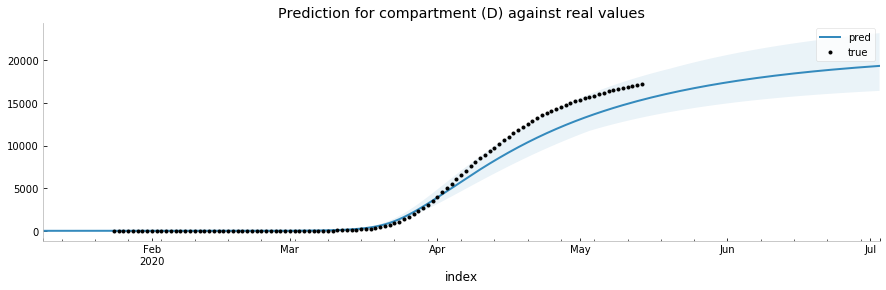

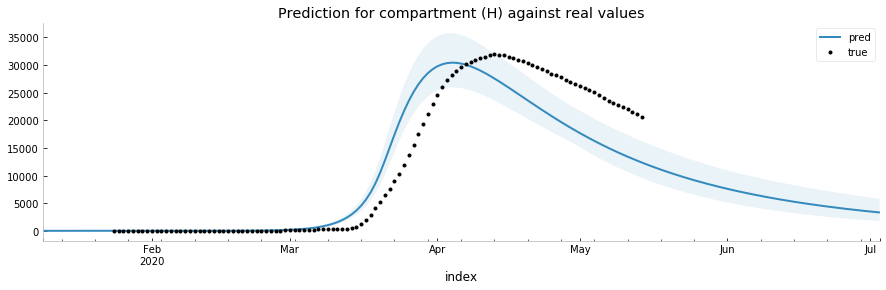

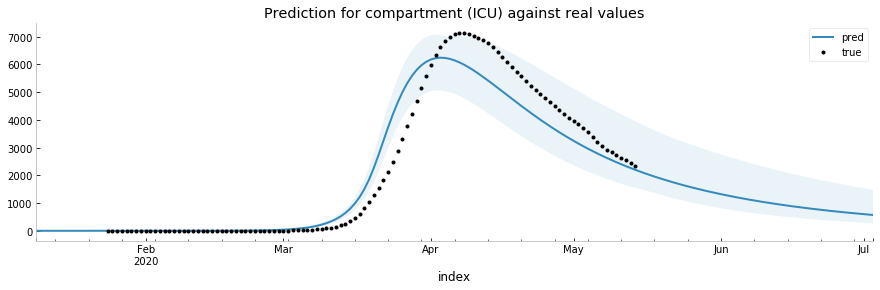

In [87]:
model.show_prediction_interval(cases[["D","H","ICU"]],1,forecast_days=50,q = 0.05,only_pred=False)